In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
def download_file_drive(file_name,out_file_name):
  drive_service = build('drive', 'v3')
  results = drive_service.files().list(
          q="name = '"+file_name+"'", fields="files(id)").execute()
  kaggle_api_key = results.get('files', [])
  try:
    os.makedirs(os.path.dirname(out_file_name), exist_ok=True)
  except:
    pass
  try:
    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(out_file_name, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(out_file_name, 600)
    return True
  except:
    return False

!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# from google.colab import auth
from oauth2client.client import GoogleCredentials
#@title Functions
def upload_to_drive(filename):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  to_upload = drive.CreateFile({'title': filename})
  to_upload.SetContentFile(filename)
  to_upload.Upload()
  return to_upload
download_file_drive('fna_all.7z','fna_all.7z')

    100% |████████████████████████████████| 993kB 8.6MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
Download 15%.
Download 30%.
Download 45%.
Download 60%.
Download 75%.
Download 90%.
Download 100%.


True

In [2]:
!7z x  fna_all.7z
!pip install Biopython
!mkdir models


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 693971359 bytes (662 MiB)

Extracting archive: fna_all.7z
--
Path = fna_all.7z
Type = 7z
Physical Size = 693971359
Headers Size = 387
Method = LZMA2:24
Solid = +
Blocks = 2

  0%      0% - non_viral_test.fna_1000.fna                                    1% - non_viral_test.fna_1000.fna                                    2% - non_viral_test.fna_1000.fna                                    3% - non_viral_test.fna_1000.fna                                  

In [3]:
import os
import re
import gzip
import random
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from contextlib import redirect_stdout
import argparse

import keras
from keras import callbacks
from keras import optimizers
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM,Dropout,GRU,RNN
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from Bio import SeqIO


Using TensorFlow backend.


In [0]:
model_name='baseline'
input_dim=500 
output_dim=1
nn=128
n_layers=1
ep=20
batch_size=512
data_dir=''

experiment_name='{0}_I{1}_L{2}_N{3}_ep{4}'.format(model_name,input_dim,n_layers,nn,ep)
data_file='{0}_{1}.fna_{2}.csv'
model_path='models/model_'+experiment_name+'{epoch:02d}-{val_acc:.2f}.h5'
genomes=['archaea','bacteria','viral']
logs=[]

In [0]:
def load_fasta(file_path,label=1,num_limit=1000000):
    data_list=[]
    for record_indx,record in enumerate(SeqIO.parse(file_path, "fasta")):
        if num_limit is not None and record_indx==int(num_limit*1.0/2):
          break
        data_list.append([str(record.seq)])
    print('Loaded {0} fragments'.format(len(data_list)))

    df=pd.DataFrame(data_list,columns=['SEQ'])
    df['LABEL']=label #is vira or not
    return df

def load_csv(file_path):
    df=pd.read_csv(file_path)
    if('viral' in file_path):
        df['LABEL']=1
    else:
        df['LABEL']=0
    return df

def process_data(df_train):
    print('Preporcessing and Decoding SEQ chars')
    dna_dict={'A':1,'C':2,'G':3,'T':4,'N':5,' ':0}
    def decode(seq):
        new_seq=np.zeros(input_dim)
        seq=re.sub(r'[^ATGCN]','N',seq.upper())
        for i in range(len(seq[:input_dim])):
            new_seq[i]=dna_dict[seq[i]]
        return new_seq.astype(np.int)

    def one_hot_encode(x, n_classes):
        return np.eye(n_classes)[x]

    """    
    dna_list=[' ','A','C','G','T','N']
    def encode(seq):
        new_seq=[]
        for i in seq:
            new_seq.append(dna_list[i])
        return ''.join(new_seq) 
    """
    df_train['SEQ']=df_train['SEQ'].apply(decode)
    X_train=df_train['SEQ'].values.tolist()
    y_train=df_train['LABEL'].values

    X_train=np.array(X_train).reshape(len(X_train),input_dim,1)
    #y_train=one_hot_encode(y_train,output_dim)

    print('Suffle data')
    X_train , y_train = shuffle(X_train, y_train, random_state=42)
    print(X_train.shape)
    return X_train,y_train


# ## Training model
def create_model(model_name,input_dim,output_dim,nn,n_layers):
    print('Creating {0} Model'.format(model_name))
    model = Sequential()
    if model_name is 'lstm':
        rnn_cell=LSTM
    elif model_name is 'gru':
        rnn_cell=GRU
    else:
        rnn_cell=RNN
    for i in range(n_layers):
        model.add(rnn_cell(nn,kernel_initializer='normal',input_shape=(input_dim,1),return_sequences=True,recurrent_dropout=0.1))
    model.add(rnn_cell(nn,kernel_initializer='normal',recurrent_dropout=0.1))
    model.add(Dropout(0.2))
    model.add(Dense(nn//2,kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim,kernel_initializer='normal', activation='sigmoid'))
    print(model.summary())
    with open('experiments/{0}_model_arc.txt'.format(experiment_name), 'w') as f:
        with redirect_stdout(f):
            model.summary()
    return model

def train_model(model,X_train,y_train):
    print('Training starting ... ')
    start_t=time.time()
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_acc', verbose=1)
    #earlystop = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=4, verbose=1)
    history=model.fit(np.array(X_train),y_train,batch_size=batch_size, shuffle=True, epochs=ep,validation_split=0.2,verbose=2,callbacks=[checkpoint])
    end_t=time.time()
    logs.append('Training time\t{0:.2f} sec\n'.format(end_t-start_t))
    return history

def load_nn_model(model,model_path):
    model.load_weights(model_path)
    return model

def plot_train(history):
    plt.subplot(2, 1, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    #plt.savefig('experiments/{0}_train_curve.png'.format(experiment_name))
    

def plot_roc_curve(y_test,y_prop):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y_test, y_prop)
    roc_auc[0] = auc(fpr[0], tpr[0])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prop.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
            lw=lw, label='ROC-AUC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig('experiments/{0}_roc_curve.png'.format(experiment_name))

def predict_classes(proba):
    thresh=0.5
    if proba.shape[-1] > 1:
        return proba.argmax(axis=-1)
    else:
        return (proba > thresh).astype('int32')

def evaluate_model(model,X_test,y_test):
    print('Evaluate model ... ')
    start=time.time()
    target_names = ['Not Virus', 'Virus']
    y_prop=model.predict(X_test)
    end=time.time()
    y_pred=predict_classes(y_prop)
    logs.append(str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))+'\n')
    logs.append('Accuracy:\t{0:.2f}%\n'.format(accuracy_score(y_test, y_pred)*100))
    logs.append('Classification Report:\n{0}\n'.format(classification_report(y_test, y_pred, target_names=target_names)))
    logs.append('ROC-AUC:\t{0:.2f}\n'.format(roc_auc_score(y_test, y_pred)))
    logs.append('Predicting time\t{0:.2f} sec\n'.format(end-start))
    plot_roc_curve(y_test,y_pred)
    print(''.join(logs))


In [0]:
from keras import initializers
from keras.engine import InputSpec, Layer
from keras import backend as K


class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None
# -*- coding: utf8 -*-
from sklearn.base import BaseEstimator, ClassifierMixin
from keras import optimizers
from sklearn.metrics import roc_auc_score
from keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Activation,GRU,TimeDistributed, MaxPooling1D, Convolution1D,Conv1D
from keras.layers.merge import Concatenate,Multiply
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,BatchNormalization,Lambda
from keras.models import Model
from keras.layers import merge
from keras.layers.recurrent import LSTM
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
import tensorflow as tf
from keras import callbacks
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential 
from keras import backend as K 
from keras.layers.core import *
import numpy as np


class NeuralClassifier(BaseEstimator, ClassifierMixin):  
    """An example of classifier"""

    def __init__(self,attention=True,nclasses=1,nepochs = 8,type='lstm',patience = 2,batch_size = 128,embeddings = None,embed_size = 30,vocab_size = None,maxlen = 167,nlayers = 1,ngpus = 1,val_set = 0.005):
        """
        Called when initializing the classifier
        """
        self.ngpus = ngpus
        self.maxlen = maxlen
        self.nclasses = nclasses
        self.nepochs = nepochs
        self.batch_size = batch_size
        self.file_path="weights_base.best.hdf5"
        self.val_size = val_set
        self.model = None
        self.embeddings = embeddings 
        self.embed_size = embed_size
        if self.embeddings is not None:
            self.embed_size = self.embeddings.embedding_size
        self.vocab_size = vocab_size
        self.attention = attention
        self.patience = patience
        self.type=  type
        self.name = type
        self.nlayers = nlayers
        self.callbacks_list = []
        self.tokenizer = None

    def lstm_model(self):

        inp = Input(shape=(self.maxlen,) )
        if self.embeddings is not None: 
            self.vocab_size = self.embeddings.embedding_matrix.shape[0]
            x = Embedding(self.vocab_size, self.embed_size, weights=[self.embeddings.embedding_matrix],trainable=False)(inp)
        else:
            x = Embedding(self.vocab_size, self.embed_size)(inp)
        for i in range(self.nlayers):
            x = LSTM(self.embed_size, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 )(x)
        if self.attention:
            x = AttentionWeightedAverage()(x)
        else:
            x = GlobalMaxPool1D()(x)
        x = Dense(self.embed_size, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(self.nclasses, activation="sigmoid")(x)
        if self.ngpus>1:
            with tf.device("/cpu:0"):
                model = Model(inputs=inp, outputs=x)
            model = multi_gpu_model(model, gpus=self.ngpus)
        else:
            model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.

        Note: assert is not a good choice here and you should rather
        use try/except blog with exceptions. This is just for short syntax.
        """
        checkpoint = ModelCheckpoint(self.file_path, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only = True, mode='min')
        early = EarlyStopping(monitor="val_loss", mode="min", patience=self.patience)
        train = X
        train_label = y
        validation_split = self.val_size
        self.callbacks_list = [ early] #early
        self.model = self.lstm_model()
        if validation_split==0:
            self.callbacks_list = []
        history = self.model.fit(train, train_label, batch_size=self.batch_size, epochs=self.nepochs, validation_split=validation_split,callbacks =self.callbacks_list ,shuffle=False)
        return history


    def predict(self, X):
        #self.model.load_weights(self.file_path)
        return self.model.predict([X],batch_size=1024, verbose=1)

    def predict_proba(self, X):
        return self.predict(X)

    def score(self, X=None, y=None):
        # counts number of values bigger than mean
        if X is None and y is None:
            return roc_auc_score(self.val_label,self.model.predict(self.val))
        else:
            return roc_auc_score(y,self.model.predict(X))
          
    def word_break(self,sentences,ngrams=3):
        if ngrams==0:
            retrun sentences
        result = [ re.sub(r'(.{'+str(ngrams)+'})',r'\1 ',sent).strip() for sent in sentences]
        return result
      
    def tokenize_train(self,train_sentences):
        if self.vocab_size is not None:
            self.tokenizer = Tokenizer(num_words=self.vocab_size,char_level=False)
        else:
            self.tokenizer = Tokenizer(char_level=False)
        self.tokenizer.fit_on_texts(self.word_break(train_sentences))
        self.vocab_size = len(self.tokenizer.word_index)
        if self.embeddings is not None:
            self.embeddings.set_embeddings_matrix(self.tokenizer.word_index,self.vocab_size)

    def tokenize(self,sentences):
        list_tokenized = self.tokenizer.texts_to_sequences(self.word_break(sentences))
        return pad_sequences(list_tokenized , maxlen=self.maxlen)

    def tokenize_set(self,train_sentences,test_sentences): 
        self.tokenize_train(list(train_sentences)+list(test_sentences))
        X_t =self.tokenize(list(train_sentences))
        X_te = self.tokenize(list(test_sentences))
        return X_t,X_te

In [7]:
def show_loss(history,name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
print('Starting Experiment {0}'.format(experiment_name))
df_train = pd.concat([load_fasta('viral_train.fna_500.fna',1),load_fasta('non_viral_train.fna_500.fna',0)])
df_train = df_train.sample(frac=1).reset_index(drop=True)

y_train=df_train['LABEL'].values
  
df_test = pd.concat([load_fasta('viral_test.fna_500.fna',1),load_fasta('non_viral_test.fna_500.fna',0)])
y_test =df_test['LABEL'].values
  


Starting Experiment baseline_I500_L1_N128_ep20
Loaded 420857 fragments
Loaded 500000 fragments
Loaded 106168 fragments
Loaded 174566 fragments


In [8]:
model = NeuralClassifier()
X_train,X_test = model.tokenize_set(df_train['SEQ'].values,df_test['SEQ'].values)
history = model.fit(X_train,y_train)

Train on 916252 samples, validate on 4605 samples
Epoch 1/8
916252/916252 [==============================] - 3135s 3ms/step - loss: 0.5659 - acc: 0.7057 - val_loss: 0.5501 - val_acc: 0.7199
Epoch 2/8
916252/916252 [==============================] - 3142s 3ms/step - loss: 0.5432 - acc: 0.7239 - val_loss: 0.5305 - val_acc: 0.7307
Epoch 3/8
916252/916252 [==============================] - 3157s 3ms/step - loss: 0.5209 - acc: 0.7400 - val_loss: 0.5091 - val_acc: 0.7485
Epoch 4/8
916252/916252 [==============================] - 3145s 3ms/step - loss: 0.4999 - acc: 0.7541 - val_loss: 0.4824 - val_acc: 0.7618
Epoch 5/8
916252/916252 [==============================] - 3148s 3ms/step - loss: 0.4781 - acc: 0.7687 - val_loss: 0.4619 - val_acc: 0.7776
Epoch 6/8
916252/916252 [==============================] - 3163s 3ms/step - loss: 0.4609 - acc: 0.7802 - val_loss: 0.4454 - val_acc: 0.7878
Epoch 7/8
916252/916252 [==============================] - 3157s 3ms/step - loss: 0.4483 - acc: 0.7888 - val_l

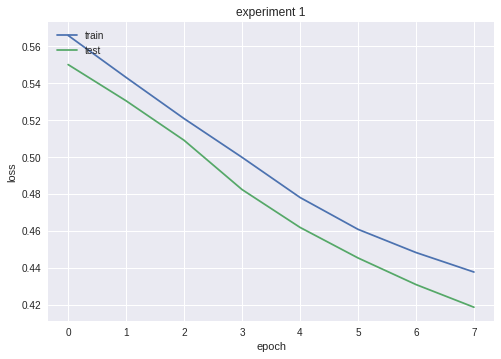

In [9]:
show_loss(history,'experiment 1')

Loaded 106168 fragments
Loaded 174566 fragments
Evaluate model ... 
280734/280734 [==============================] - 31s 111us/step


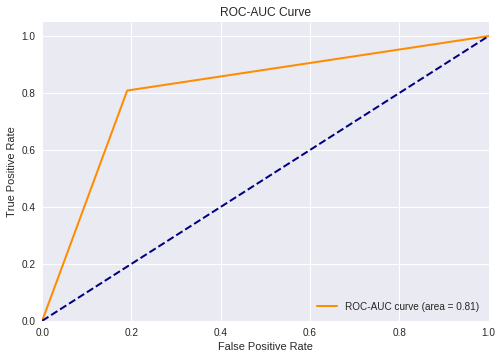

2018-09-23 17:01
Accuracy:	80.92%
Classification Report:
             precision    recall  f1-score   support

  Not Virus       0.87      0.81      0.84    174566
      Virus       0.72      0.81      0.76    106168

avg / total       0.82      0.81      0.81    280734

ROC-AUC:	0.81
Predicting time	31.21 sec



In [10]:
del df_train
del df_test
del y_train
del y_test
del X_train
del X_test
import gc
gc.collect()
df_test = pd.concat([load_fasta('viral_test.fna_500.fna',1,None),load_fasta('non_viral_test.fna_500.fna',0,None)])
y_test =df_test['LABEL'].values
X_test = model.tokenize(df_test['SEQ'].values)
del df_test
evaluate_model(model,X_test,y_test)